In [1]:
import numpy as np
import scipy
import scipy.stats as sps

import statsmodels as sm
import statsmodels.api as sma
from statsmodels.stats.multitest import multipletests
import pandas as pd
import matplotlib.pyplot as plt

# Homework 2
## Hypothesis testing

Each task is worth 5 points, 20 points in total. Additionally, some tasks allow you to get a bonus point, that **can not** increase your total score for the homework beyond the maximum, but can compensate for some occasionally lost points.

### Task 1: multiple comparisons

A randomized, double-blind experiment was conducted to assess the
effectiveness of several drugs for reducing postoperative nausea. The
data are as follows:

In [2]:
df1 = pd.DataFrame({'Drug': ['Placebo', 'Chlorpromazine', 'Dimenhydrinate', 'Pentobarbital (100 mg)', 'Pentobarbital (150 mg)'],
                    'Number of Patients': [80, 75, 85, 67, 85],
                    'Incidence of Nausea': [45, 26, 52, 35, 37]})
df1

,Drug,Number of Patients,Incidence of Nausea
0,Placebo,80,45
1,Chlorpromazine,75,26
2,Dimenhydrinate,85,52
3,Pentobarbital (100 mg),67,35
4,Pentobarbital (150 mg),85,37


1. Test each drug versus the placebo at the 5% level. Also, report
the estimated odds–ratios. Summarize your findings. (2 points)

*Hint*. Use simple $H_0$: "$p = p_0$".

##### Let us formulate hypotheses like this:
$\delta = p - p_0$, where $p_0$ is the measure of the placebo effectiveness.

$H_0$: $p - p_0 = 0$ vs. $H_1$: $p - p_0 \neq 0$.

##### Since we can assume that our data distributed according to binomial distribution (~$Binom(n,p)$), then we know that for big values of $n$:
##### $Binom(n, p) \approx N(np, npq)$, so we can apply Wald test, which says that if $\hat{\theta}$ is asymptotically normal:
##### $\dfrac{\hat{\delta} - \delta_0}{\hat{se}} \rightarrow N(0, 1)$
#### then size $\alpha$ Wald test rejects $H_0$ if $|W| > z_{\alpha / 2}$, where $W = \dfrac{\hat{\delta} - \delta_0}{\hat{se}}$.
##### We'll estimate $p$ and $se$ as: 
$\hat{\delta} = \hat{p} - \hat{p_0}$

$\hat{p} = \frac{\sum_{i=1}^n X_i}{n} = \frac{n_+}{n}$,

$\hat{se_i} = \sqrt{\frac{\hat{p_i}(1-\hat{p_i})}{n}}$

$\hat{se} = \sqrt{\hat{se}_1^2 + \hat{se}_2^2}$

In [3]:
p = [] # MLE for 'probability' of nausea
n = [] #num patirnts for each griup
p0 = (df1[df1.Drug == 'Placebo']['Incidence of Nausea'] / df1[df1.Drug == 'Placebo']['Number of Patients']).values[0]
n0 = df1[df1.Drug == 'Placebo']['Number of Patients'].values[0]
for drug in df1.Drug:
    if (drug == 'Placebo'):
        continue
    else:
        #df1['p'] = df1[df1.Drug == drug]['Incidence of Nausea'] / df1[df1.Drug == drug]['Number of Patients']).values[0]
        p.append((df1[df1.Drug == drug]['Incidence of Nausea'] / df1[df1.Drug == drug]['Number of Patients']).values[0])
        n.append((df1[df1.Drug == drug]['Number of Patients']).values[0])

def wald_test_for_proba(mean1, mean2, n1, n2, alpha=0.05):
    dif = mean1 - mean2
    se = np.sqrt(mean1 * (1 - mean1) / n1 + mean2 * (1 - mean2) / n2)
    z_a = sps.norm.ppf(1 - alpha / 2)
    statistic = np.abs(dif / se)
    is_h0 = statistic <= z_a
    pvalue = 2 * sps.norm.cdf(-statistic)
    return statistic, pvalue, is_h0

for i in range(len(p)):
    statistic, pvalue, is_h0 = wald_test_for_proba(p[i], p0, n[i], n0)

    print("For drug " + df1.iloc[i + 1].Drug +  " got p-value = " + str(pvalue))
    #if (pvalue < 0.05):
    if (not is_h0):
        print("Hypothesis H0 rejected\n")
    else:
        print("Not enough reasons to reject hypothesis H0\n")

For drug Chlorpromazine got p-value = 0.005703391555257745
Hypothesis H0 rejected

For drug Dimenhydrinate got p-value = 0.5202323654229462
Not enough reasons to reject hypothesis H0

For drug Pentobarbital (100 mg) got p-value = 0.6266640947313886
Not enough reasons to reject hypothesis H0

For drug Pentobarbital (150 mg) got p-value = 0.09963923341820242
Not enough reasons to reject hypothesis H0



In [4]:
for i in range(len(p)):
    odds = p[i] * (1 - p0) / (p0 * (1 - p[i]))
    print("drug " + df1.iloc[i + 1].Drug + ", odds: " + str(odds))
    if (odds > 0.75 and odds < 1.25):
        print("Almost equal chances of nausea to occur for this drug and placebo\n")
    elif (odds > 0.9):
        print("More chances of nausea to occur for this drug than for placebo\n")
    else:
        print("More chances of nausea to occur for placebo than for this drug\n")

drug Chlorpromazine, odds: 0.41269841269841273
More chances of nausea to occur for placebo than for this drug

drug Dimenhydrinate, odds: 1.225589225589226
Almost equal chances of nausea to occur for this drug and placebo

drug Pentobarbital (100 mg), odds: 0.8506944444444444
Almost equal chances of nausea to occur for this drug and placebo

drug Pentobarbital (150 mg), odds: 0.5995370370370371
More chances of nausea to occur for placebo than for this drug



##### At 5% level of significance we can only reject the null hypothesis for Chlorpromazine (odds ratio confirms that it has lower chances to cause nausea than placebo which means it's effect is significantly different). But if we increase the significance level to 10% then we can also reject H0 for Pentobarbital (150 mg) and it corresponds to the odds-ratio.

2. Use the Bonferroni and the FDR method to adjust for multiple
testing. (Beecher (1959)) (3 points)

In [5]:
pvalues_ttest = []
alpha = 0.05
bonferroni_test_pass = np.zeros(len(p))

for i in range(len(p)):
    hypothesis_mean = np.abs((p[i] - p0) / np.sqrt(p[i] * (1 - p[i]) / n[i] + p0 * (1 - p0) / n0))
    pvalues_ttest.extend([2 * sps.norm.cdf(-hypothesis_mean)])#[sps.ttest_1samp(x, hypothesis_mean)[1]] 

#for method in ["bonferroni", "fdr_bh"]:
#    print('Method: ', method)
#    reject, pvals, _, _ = multipletests(pvalues_ttest, method=method, returnsorted=True)
print("Bonferroni:") 
for i in range(len(p)):
    bonferroni_test_pass[i] = pvalues_ttest[i] < alpha / 4
    drug = df1.iloc[i + 1]
    print('drug: ', drug.values[0], ', reject H0: ', True if bonferroni_test_pass[i] else False)
    
print("\nFdr-bh")
m = 4
largest_i = 0
fdr_bh = []
sort_p = np.argsort(p)
for i in range(len(p)):
    sign = (i+1) * alpha / m
    if (pvalues_ttest[sort_p[i]] >= sign):
        fdr_bh.extend([True] * (m- i))
        break
    else:
        fdr_bh.append(False)
print("Is H0 rejected:")
print([not fdr_bh[i] for i in range(len(fdr_bh))])

Bonferroni:
drug:  Chlorpromazine , reject H0:  True
drug:  Dimenhydrinate , reject H0:  False
drug:  Pentobarbital (100 mg) , reject H0:  False
drug:  Pentobarbital (150 mg) , reject H0:  False

Fdr-bh
Is H0 rejected:
[True, False, False, False]


##### We got the same results for our significance level: $H_0$ is only rejected in first case for Chlorpromazine. Moreover, even if we increase $\alpha$ to $0.1$ we'll still get the same result, which is different from the results above when for Pentobarbital (150 mg) we rejected $H_0$ for significance level equal to $0.1$. 

3. Reproduce plot similar to Figure 10.6 from the book, displaying observed $p$-values and different thresholds used (1 bonus point)

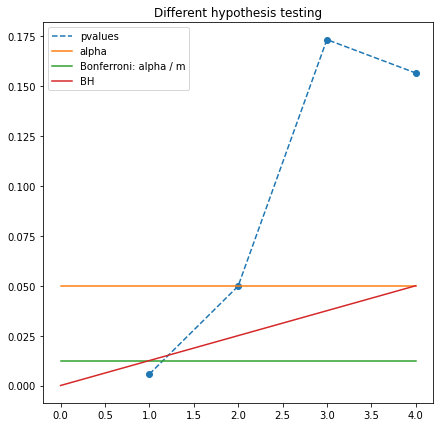

In [6]:
plt.figure(figsize = (7, 7))
plt.scatter(range(1, 5), np.sort(np.array(pvalues_ttest)) / np.arange(1, 5))
plt.plot(range(1, 5), np.sort(np.array(pvalues_ttest))/ np.arange(1, 5), '--', label = 'pvalues')
plt.plot(range(5), [alpha] * 5, label = 'alpha')
plt.plot(range(5), [alpha / 4] * 5, label = 'Bonferroni: alpha / m')
plt.plot(range(5), [i * alpha / 4 for i in range(5)], label = 'BH')
plt.legend()
plt.title("Different hypothesis testing")
plt.show()

### Task 2: permutation test

For this task we will use the famous Iris dataset, originaly studied by R.A. Fisher himself.

In [7]:
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


We will select two species: *setosa* and *virginica* and study the sepal length.

In [8]:
X = iris[iris.species == 'setosa']['sepal_width'].values
Y = iris[iris.species == 'virginica']['sepal_width'].values

In [9]:
X.shape

(50,)

Test the hypothesis $H_0$: quantile of level 0.2 (20 percentile, lower 20%) of the sepal length of *setosa* flowers is  larger than that of *virginica* flowers. Use permutation test, approximate the full permutation distribution with 10,000 samples. (5 points)


In [10]:
qt_level = 0.2
np.quantile(X, qt_level) - np.quantile(Y, qt_level)

0.3999999999999999

##### From this it look like quantile of level 0.2 of the sepal width of *setosa* flowers is  larger than that of *virginica* flowers. But in order to say how statistically signigicant if this result we need to perform permutation test. This means we'll join our two samples, permute it and take some new samples from it. Then we'll count the percentage of cases when the statistic on such samples is larger than on our gven samples. This percentage is our approximate p-value. If it's lower than the significance level then our outcome has proved to be statistically significant and we can reject $H_0$.
##### $H_0$: "quantiles of level 0.2 of both flowers are equal"
##### $H_1$: "quantile of level 0.2 (20 percentile, lower 20%) of the sepal width of *setosa* flowers is  larger than that of *virginica* flowers"

In [11]:
n_runs = 10000
def T(X, Y, quantile_level = qt_level):
    return np.quantile(X, quantile_level) - np.quantile(Y, quantile_level)

In [12]:
def permutation_test(statistic, sample1, sample2, n_runs = n_runs):
    l1 = len(sample1)
    t_obs = statistic(sample1, sample2)
    sample_joint = np.r_[sample1, sample2]
    counter = 0
    t_samp = []
    for i in range(n_runs):
        sample_joint = np.random.permutation(sample_joint)
        t = statistic(sample_joint[:l1], sample_joint[l1:])
        t_samp.append(t)
        counter += t > t_obs

    return counter / n_runs, t_samp

In [13]:
pvalue, samples = permutation_test(T, X, Y)
print('pvalue =', pvalue)

pvalue = 0.0


#### Such p-value tells us that the is almost no chances to see the difference between the quantile of level 0.2 of the sepal width of setosa flowers and the one of virginica flowers this large as it is in our case assuming that null hypothesis is true. This means that we reject the null hypothesis and accept alternative, but for our testing it only means that the quantiles are not equal. We cannot say for sure whether the quantile of level 0.2 of the sepal width of setosa flowers is larger than this quantile of virginica flowers.
##### To illustrate our conclusions, let us look at the distribution of the simulated values that we got in permutation test. Since these are permuted values, it doesn't have to make a lot of sense but one thing still can be noticed. We can truly see that this distribution doesn't intersect with the value of difference of quantiles given in our dataset, not to mention exceed it.

/home/nina/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


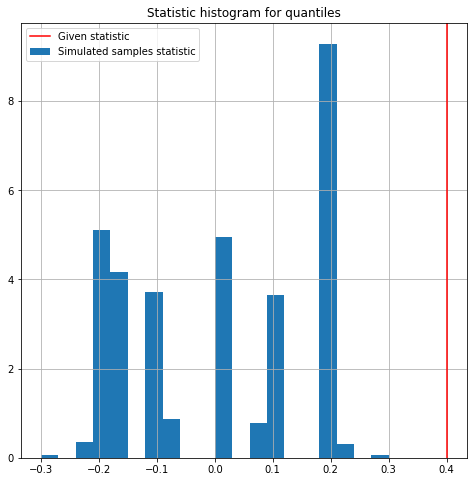

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.axvline(T(X, Y), color='r', label='Given statistic')
ax.hist(samples, density=True, bins=20, label='Simulated samples statistic')
ax.legend()
ax.set_title("Statistic histogram for quantiles")
ax.grid()
fig.show()

### Task 3: computational approach to hypothesis testing

Recommended reading: http://allendowney.blogspot.com/2016/06/there-is-still-only-one-test.html

Consider the following dataset (service hours between failures of the air-conditioning equipment in a Boeing 720 jet aircraft , Proschan, 1963):

In [15]:
Y = np.array([3, 5, 7, 18, 43, 85, 91, 98, 100, 130, 230, 487])

This sample was sorted for easier presentation.

1. Compute an estimate of the median time between failures (1 point)

##### To estimate a median time we'll use sample median.

In [16]:
#time_bw_failure = np.array([Y[i] - Y[i-1] for i in range(1, len(Y))])
#np.median(time_bw_failure)
sample_med = np.median(Y)
print("Median time in hours:", sample_med)
print("Median time in days:", sample_med / 24.)

Median time in hours: 88.0
Median time in days: 3.6666666666666665


2. Consider the null hypothesis $H_0$ to be: "median time between failures is one week" (1 point)

##### H0 : median time between failures is equal to 168 hours ($median(Y) = 168$)
##### H1 : median time  between failures is not equal to 168 hours ($median(Y) \neq 168$)

##### From the first look it seems that the null hypothesis isn't true because for our sample the deviation in sample median and proposed median is too big. But in order to get statistically significant result we have to choose a statistic and perform some tests for these hypotheses.

3. What distribution will you choose for this kind of data under $H_0$? (1 point)

##### I think we should consider exponential distribution which is defined as a time between two consecutive occurrences of the same event which is relevant for our case. 
##### It has one parameter $\lambda$ which is intensity or inverse scale factor and its median is equal to $ln(2)/\lambda$.
#####  We can also perform  quantile-quantile plot and see if this family of distributions looks suitable.

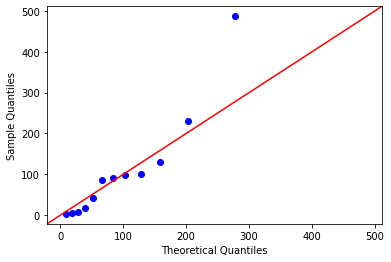

In [17]:
from statsmodels.graphics.gofplots import qqplot

qqplot(Y, sps.expon,  line='45', fit=False, scale=np.mean(Y))
plt.show()

In [18]:
assumed_med = 168
lambda0 = np.log(2) / assumed_med
def exp_model(n_samples, lmbd = lambda0):
    return sps.expon.rvs(scale = 1/lmbd, size = n_samples)

4. Choose a statistic to measure the deviation from $H_0$ (effect size) (1 point)

##### Since we have to chect whether the median is equal to 168 hours or not we can consider as a statistic a difference of the proposed median which is equal to 168 and the median of a sample. We also take a modulus of this difference because our goal is only to check whether if differs from $0$ or not.

In [19]:
def T(sample, sp_median = assumed_med):
    return np.abs(np.median(sample) - sp_median)

5. Check whether you can reject $H_0$ at significance level 5% and calculate the corresponding approximate $p$-value. Use 10,000 simulations for your experiment (1 point)

##### We'll perform the procedure similar to the permutation test, but instead of doing permutation of the initial sample we'll take samples from exponential distribution and consider thether the statistic on this sample is larger than on the initial, given sample. By counting the percentage of such event, we'll have the p-value.

In [20]:
alpha = 0.05
n_runs = 10000

def median_exp_test(X, statistic, model, n_runs = n_runs):
    sampled_Y = []
    t_obs = statistic(X)
    size = X.shape[0]
    counter = 0
    for i in range(n_runs):
        sample = model(size)
        t = statistic(sample)
        sampled_Y.append(t)
        counter += (t > t_obs)
    return counter / n_runs, sampled_Y

p_value, t_sim = median_exp_test(Y, T, exp_model)
print('Approximate p_value:', p_value)

Approximate p_value: 0.2135


In [21]:
p_value > 0.05

True

##### We cannot reject the null hypothesis because the result is not statistically significant at level equal to 5%. 
##### We could only reject H0 with higher significance level (which means if we would accepted higher probability of making 1-type error - rejecting H0 when it's actually true). If we don't take such a risk we stay with our null hypothesis. 

6. Plot histogram of simulated effect sizes and mark the observed effect size (1 bouns point)

/home/nina/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


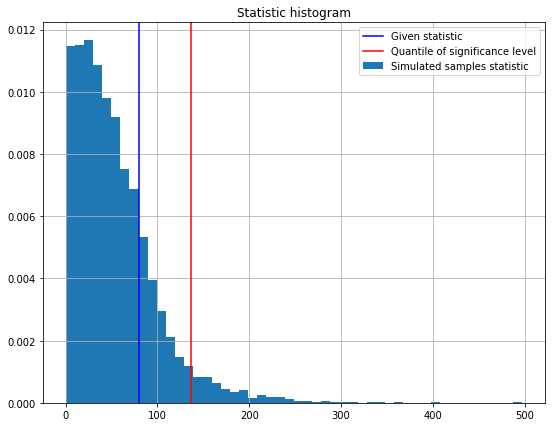

In [22]:
fig, ax = plt.subplots(figsize=(9, 7))
ax.axvline(T(Y), color='b', label='Given statistic')
ax.axvline(np.quantile(t_sim, 0.95), color='r', label='Quantile of significance level')
ax.hist(t_sim, density=True, bins=50, label='Simulated samples statistic')
ax.legend()
ax.set_title("Statistic histogram")
ax.grid()
fig.show()

### Task 4: power analysis

In 1861, 10 essays appeared in the New Orleans Daily Crescent. They
were signed “Quintus Curtius Snodgrass” and some people suspected
they were actually written by Mark Twain. To investigate this, we will
consider the proportion of three letter words found in an author’s work.
From eight Twain essays we have:

In [23]:
X = np.array([.225, .262, .217, .240, .230, .229, .235, .217])

From 10 Snodgrass essays we have:

In [24]:
Y = np.array([.209, .205, .196, .210, .202, .207, .224, .223, .220, .201])

1. Perform a Wald test for equality of the means. Use the nonparametric plug-in estimator. Report the p-value and a 95% confidence
interval for the difference of means. What do you conclude? (1.5 points)

##### As nonparametric plug-in estimator we'll use sample mean and sample variance. 
##### Let us have:
$\delta = \mu_X - \mu_Y$, 

$\hat{\delta} = \bar{X} - \bar{Y}$, where $\bar{X}$ and $\bar{Y}$ are sample means,

$\hat{se} = \sqrt{\frac{\hat{s}_1^2}{m} + \frac{\hat{s}_2^2}{n}}$, $\hat{s}^2_1$ and $\hat{s}^2_2$ are the sample variances.

The hypothesis is formulated as follows:

$H_0$: $\delta = 0$ vs. $H_1$: $\delta \neq 0$.

In [25]:
alpha = 0.05

X_mean = np.mean(X)
Y_mean = np.mean(Y)
print('Mean of X:', X_mean)
print('Mean of Y:', Y_mean)
X_var = np.var(X)
Y_var = np.var(Y)

def wald_test_new(mean1, mean2, var1, var2, n1, n2, h0 = 0, alpha=alpha):
    dif = mean1 - mean2
    se = np.sqrt(var1 / n1 + var2 / n2)
    z_a = sps.norm.ppf(1 - alpha/2)
    statistic = np.abs((dif - h0) / se)
    pvalue = 2 * sps.norm.cdf(-statistic)
    is_h0 = 'accepted' if statistic <= z_a else 'rejected'
    conf_interval = (dif - se * z_a, dif + se * z_a)
    return pvalue, is_h0, conf_interval

Mean of X: 0.231875
Mean of Y: 0.2097


In [26]:
pvalue_twain, is_h0, interval = wald_test_new(X_mean, Y_mean, X_var, Y_var, X.shape[0], Y.shape[0])
print('Got pvalue', pvalue_twain)
print('Hypothesis H0 is', is_h0)
print('Confidence interval:', interval)
if ((interval[0] < 0) and (interval[1] > 0)):
    is_in_interval = 'in'
else:
    is_in_interval = 'not in'
print('delta = 0 ' + is_in_interval + ' the confidence interval')

Got pvalue 7.9926649561458e-05
Hypothesis H0 is rejected
Confidence interval: (0.011156903889404914, 0.03319309611059509)
delta = 0 not in the confidence interval


##### We can reject the null hypothesis either by applying Wald criterion (comparing our statistic with the quantile) or by looking at the confidence interval which does not include $\delta = 0$ (corresponding to $H_0$). 
##### Low p-value confirms our decision to accept alternative hypothesis.

2. Now use a permutation test to avoid the use of large sample methods.
What is your conclusion? (Brinegar (1963)) (1.5 points)

##### For the permutation test we suggest the null hypothesis $H_0$: distributions for $X$ and $Y$ are the same ($F_X = F_Y$), vs. alternative hypothesis $H_1$: distributions for $X$ and $Y$ are different. 
##### As a test statistic we take difference of two means: $T = | \bar{X} - \bar{Y} |$, and now we do a permutation test (the function is provided above for one of the previous tasks, now it's the same):

In [27]:
def T(X, Y):
    return np.abs(np.mean(X) - np.mean(Y))

pvalue_twain, _ = permutation_test(T, X, Y, n_runs=50000)
print(pvalue_twain)

0.00058


##### Using permutation test we still got very low p-value ($< 0.05$) which means that we can reject $H_0$. So, we can claim that this result of difference of distributions for $X$ and $Y$ is statistically significant.

3. Assume that samples do indeed come from different populations. Additionally, observed sample means and variaces for the two samples are equal to the true values for the respective population. Estimate the power of the two tests above under two model distributions for the data: Normal and [Beta](https://en.wikipedia.org/wiki/Beta_distribution) (2 points)

##### To test the power of tests we'll create samples from two mentioned distributions a lot of times and see how often do they reject the null hypothesis when it's actually false.
##### Take significance level, as usual, equal to 5%.
##### To find the parameters for normal and beta distributions, we'll use formulas for first and second moments of these distributions, plug in sample mean and sample variance instead of them and thus express the parameters, containing in formulas for moments (formulas taken from Wikipedia)

In [28]:
def normal_model(mu, sigma, n_samples=100):
    return sps.norm.rvs(loc=mu, scale=sigma, size=n_samples)
    
def beta_model(a, b, n_samples=100):
    return sps.beta.rvs(a, b, size=n_samples)

def T(x, y):
    return np.abs(np.mean(x) - np.mean(y))

In [29]:
Wald_power = 0
Permutation_power = 0
iters = 1000
n_runs = 10000
alpha = 0.05

for _ in range(iters):
    X_1 = normal_model(X_mean, X_var, n_samples=len(X))
    Y_1 = normal_model(Y_mean, Y_var, n_samples=len(Y))
    mean1 = np.mean(X_1)
    mean2 = np.mean(Y_1)
    var1 = np.var(X_1)
    var2 = np.var(Y_1)
    pv, is_h0, c_interval = wald_test_new(mean1, mean2, var1, var2, len(X), len(Y), h0 = 0, alpha=alpha)
    Wald_power += pv < alpha
    pv, t_ = permutation_test(T, X_1, Y_1, n_runs = n_runs)
    Permutation_power += pv < alpha

In [30]:
print("Normal distribution:")
print('Power of Wald test:', Wald_power / iters)
print('Power of Permutations test:', Permutation_power / iters)

Normal distribution:
Power of Wald test: 1.0
Power of Permutations test: 1.0


In [31]:
Wald_power = 0
Permutation_power = 0
iters = 1000
n_runs = 10000
alpha = 0.05

gamma1 = X_mean * (1 - X_mean) / X_var - 1
a_1 = gamma1 * X_mean
b_1 = gamma1 - a_1
gamma2 = Y_mean * (1 - Y_mean) / Y_var - 1
a_2 = gamma2 * Y_mean
b_2 = gamma2 - a_2

for _ in range(iters):
    X_1 = beta_model(a_1, b_1, n_samples=len(X))
    Y_1 = beta_model(a_2, b_2, n_samples=len(Y))
    mean1 = np.mean(X_1)
    mean2 = np.mean(Y_1)
    var1 = np.var(X_1)
    var2 = np.var(Y_1)
    pv, is_h0, c_interval = wald_test_new(mean1, mean2, var1, var2, len(X), len(Y), h0 = 0, alpha=alpha)
    Wald_power += pv < alpha
    pv, t_ = permutation_test(T, X_1, Y_1, n_runs = n_runs)
    Permutation_power += pv < alpha

In [32]:
print("Beta distribution:")
print('Power of Wald test:', Wald_power / iters)
print('Power of Permutations test:', Permutation_power / iters)

Beta distribution:
Power of Wald test: 0.977
Power of Permutations test: 0.971


##### For both distributions we got that both tests have almost the same power. But for Beta-distribution the power is lower in general which may mean that normal distribution is preferable for this case though it is hard to say whether this difference is significant.

##### Let's lower the significance level to 1% and look at new results. 

In [37]:
Wald_power = 0
Permutation_power = 0
iters = 1000
n_runs = 10000
alpha = 0.01

for _ in range(iters):
    X_1 = normal_model(X_mean, X_var, n_samples=len(X))
    Y_1 = normal_model(Y_mean, Y_var, n_samples=len(Y))
    mean1 = np.mean(X_1)
    mean2 = np.mean(Y_1)
    var1 = np.var(X_1)
    var2 = np.var(Y_1)
    pv, is_h0, c_interval = wald_test_new(mean1, mean2, var1, var2, len(X), len(Y), h0 = 0, alpha=alpha)
    Wald_power += pv < alpha
    pv, t_ = permutation_test(T, X_1, Y_1, n_runs = n_runs)
    Permutation_power += pv < alpha

print("Normal distribution, alpha = 0.01:")
print('Power of Wald test:', Wald_power / iters)
print('Power of Permutations test:', Permutation_power / iters)

Normal distribution, alpha = 0.01:
Power of Wald test: 1.0
Power of Permutations test: 1.0


In [38]:
Wald_power = 0
Permutation_power = 0
iters = 1000
n_runs = 10000
alpha = 0.01

gamma1 = X_mean * (1 - X_mean) / X_var - 1
a_1 = gamma1 * X_mean
b_1 = gamma1 - a_1
gamma2 = Y_mean * (1 - Y_mean) / Y_var - 1
a_2 = gamma2 * Y_mean
b_2 = gamma2 - a_2

for _ in range(iters):
    X_1 = beta_model(a_1, b_1, n_samples=len(X))
    Y_1 = beta_model(a_2, b_2, n_samples=len(Y))
    mean1 = np.mean(X_1)
    mean2 = np.mean(Y_1)
    var1 = np.var(X_1)
    var2 = np.var(Y_1)
    pv, is_h0, c_interval = wald_test_new(mean1, mean2, var1, var2, len(X), len(Y), h0 = 0, alpha=alpha)
    Wald_power += pv < alpha
    pv, t_ = permutation_test(T, X_1, Y_1, n_runs = n_runs)
    Permutation_power += pv < alpha

print("Beta distribution, alpha = 0.01:")
print('Power of Wald test:', Wald_power / iters)
print('Power of Permutations test:', Permutation_power / iters)

Beta distribution, alpha = 0.01:
Power of Wald test: 0.927
Power of Permutations test: 0.871


##### We still got that for normal distribution, the tests are almost equal in power, for beta distribution, Wald test is more powerful (though for 5% significance level the difference is not so meaningful) and that normal distribution is better in avoiding 2-type errors (the tests in general are more powerful).